In [1]:
from torch import no_grad, manual_seed
import numpy as np
from PIL import Image
from random import seed

from vulture import CompleteUpsampler
from vulture.utils import to_numpy, do_2D_pca

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

SEED = 10672
np.random.seed(SEED)
manual_seed(SEED)
seed(SEED)

In [2]:
path = "example_data/boat.jpg"
img = Image.open(path).convert("RGB")

UP_PATH, DENOISE_PATH, AUTOENC_PATH = "../trained_models/lu_reg_ac48.pth", "../trained_models/dvt.pth", "../trained_models/dac_dv2_denoised_e500.pth"
upsampler = CompleteUpsampler("LOFTUP_COMPRESSED", UP_PATH, DENOISE_PATH, AUTOENC_PATH, device="cuda:0", to_half=True, to_eval=True)

with no_grad():
    lr_feats_for_vis = upsampler.get_lr_feats(img)
    hr_feats = upsampler.forward(img)

In [3]:
lr_feats_np = to_numpy(lr_feats_for_vis).astype(np.float32)
hr_feats_np = to_numpy(hr_feats).astype(np.float32)
# prep for clustering
c, h, w = hr_feats_np.shape
hr_feats_flat = hr_feats_np.reshape((c, -1)).T
# these are for vis only
lr_feats_red = do_2D_pca(lr_feats_np, 3, post_norm="minmax")
hr_feats_red = do_2D_pca(hr_feats_np, 3, post_norm="minmax")

In [ ]:
# also try `rome.jpg` with 3 or 8 clusters or cast_`iron_alloy.jpg` with 3 clusters
# we could also probably cluster the low-res and assign
K = 5
clustered = KMeans(K).fit_predict(hr_feats_flat)
class_preds = clustered.reshape((h, w))

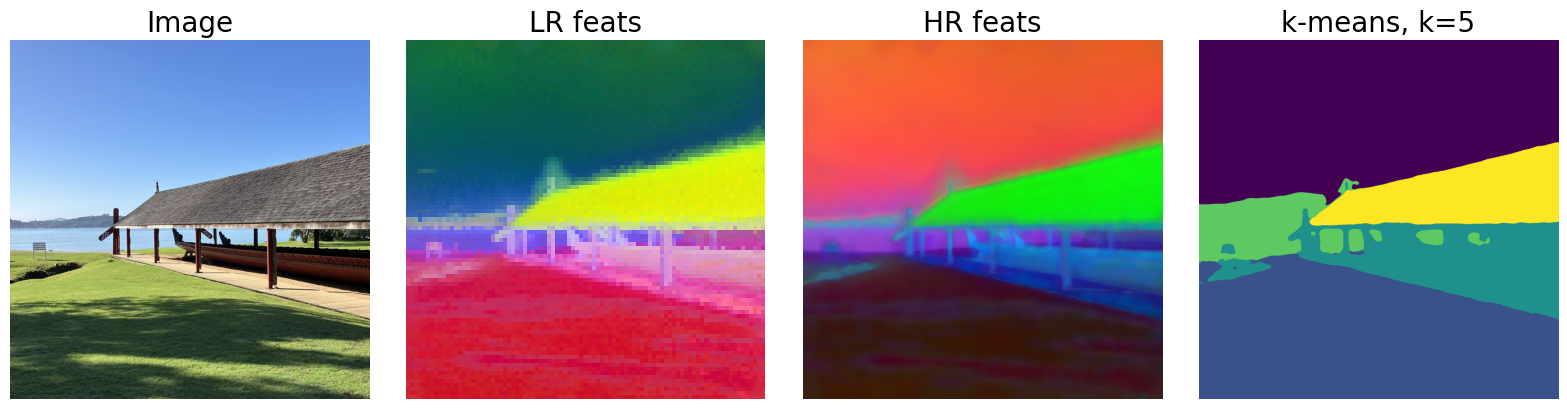

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

to_plt = [img, lr_feats_red, hr_feats_red, class_preds]
titles = ["Image", "LR feats", 'HR feats', f'k-means, k={K}']

for arr, ax, title in zip(to_plt, axs, titles):
    ax.imshow(arr)
    ax.set_axis_off()
    ax.set_title(title, fontsize=20)
plt.tight_layout()